In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, GlobalAveragePooling1D,
    Multiply, Add, BatchNormalization, Activation, Lambda, Concatenate
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [7]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [8]:

def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [9]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [10]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [11]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [12]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [13]:
def cbam_module(input_tensor, ratio=8):
    channel_avg = GlobalAveragePooling1D()(input_tensor)
    dense1 = Dense(input_tensor.shape[-1]//ratio, activation='relu')(channel_avg)
    dense2 = Dense(input_tensor.shape[-1], activation='sigmoid')(dense1)
    channel_refined = Multiply()([input_tensor, Lambda(lambda x: tf.expand_dims(x, axis=1))(dense2)])

    spatial_avg = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    spatial_max = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    spatial = Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_attention = Conv1D(1, 7, padding='same', activation='sigmoid')(spatial)
    refined_feature = Multiply()([channel_refined, spatial_attention])
    return refined_feature

In [14]:
def resnet_block(x, filters, kernel_size=3):
    # shortcut
    shortcut = x
    # conv -> BN -> relu
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # conv -> BN
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    # 차원이 맞지 않으면 1x1 Conv로 맞춤
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [15]:
inputs = Input(shape=(n_timesteps, n_features))
x = cbam_module(inputs)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

cbam_resnet_model = Model(inputs, outputs)
cbam_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cbam_resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 9)         │          0 │ input_layer_3[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         10 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 9)         │         18 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1, 9)      │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 128, 9)    │          0 │ input_layer_3[0]… │
│ (Multiply)          │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 2)    │          0 │ lambda_6[0][0],   │
│ (Concatenate)       │                   │            │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 1)    │         15 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 128, 9)    │          0 │ multiply_5[0][0], │
│ (Multiply)          │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 128, 64)   │      1,792 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 128, 64)   │     12,352 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 128, 64)   │        640 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 64)   │          0 │ conv1d_12[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 128, 64)   │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 128, 64)   │     12,352 │ activation_7[0][

 Total params: 76,913 (300.44 KB)

 Trainable params: 76,401 (298.44 KB)

 Non-trainable params: 512 (2.00 KB)

In [16]:
model_history = cbam_resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.7959 - loss: 0.5611 - val_accuracy: 0.2190 - val_loss: 3.1924
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9371 - loss: 0.1616 - val_accuracy: 0.5263 - val_loss: 2.0857
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9505 - loss: 0.1251 - val_accuracy: 0.8574 - val_loss: 0.3588
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9458 - loss: 0.1312 - val_accuracy: 0.9423 - val_loss: 0.1275
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9460 - loss: 0.1384 - val_accuracy: 0.9474 - val_loss: 0.1101
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9446 - loss: 0.1333 - val_accuracy: 0.9406 - val_loss: 0.1278
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9529 - loss: 0.1170 - val_accuracy: 0.9491 - val_loss: 0.1229
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9454 - loss: 0.1270 - val_

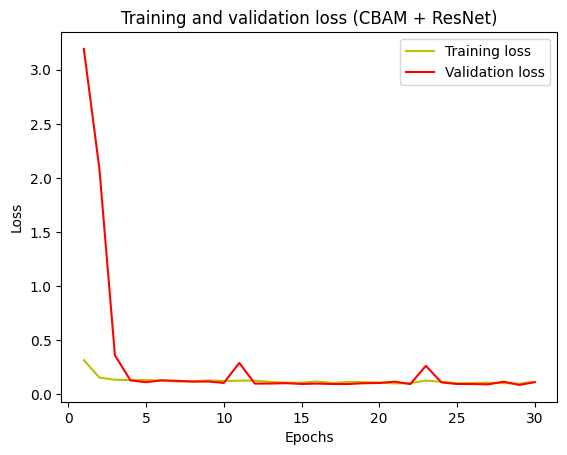

In [17]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (CBAM + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

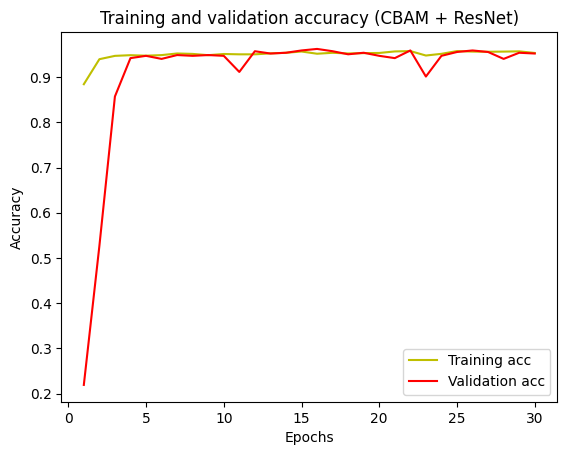

In [18]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (CBAM + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
[[490   0   6   0   0   0]
 [ 28 412  18  13   0   0]
 [  3   0 417   0   0   0]
 [  0  10   0 344 137   0]
 [  0   0   0  48 484   0]
 [  0  27   0   0   0 510]]
0.9015948422124194
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       496
           1       0.92      0.87      0.90       471
           2       0.95      0.99      0.97       420
           3       0.85      0.70      0.77       491
           4       0.78      0.91      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

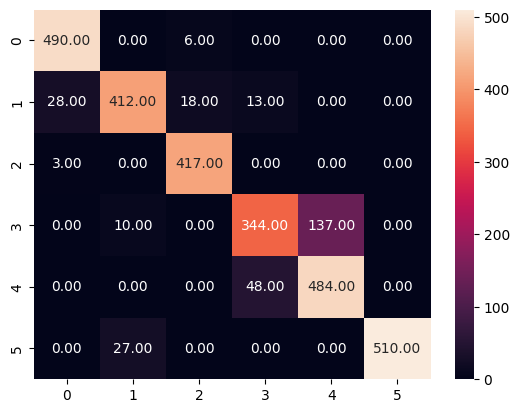

In [19]:
pred = cbam_resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')